In [11]:
"""
Title: PixelCNN
Author: [ADMoreau](https://github.com/ADMoreau)
Date created: 2020/05/17
Last modified: 2020/05/23
Description: PixelCNN implemented in Keras.
"""

"""
## Introduction
PixelCNN is a generative model proposed in 2016 by van den Oord et al.
(reference: [Conditional Image Generation with PixelCNN Decoders](https://arxiv.org/abs/1606.05328)).
It is designed to generate images (or other data types) iteratively
from an input vector where the probability distribution of prior elements dictates the
probability distribution of later elements. In the following example, images are generated
in this fashion, pixel-by-pixel, via a masked convolution kernel that only looks at data
from previously generated pixels (origin at the top left) to generate later pixels.
During inference, the output of the network is used as a probability ditribution
from which new pixel values are sampled to generate a new image
(here, with MNIST, the pixels values are either black or white).
"""

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow_probability as tfp
from keras.callbacks import History 
history = History()

In [12]:
tf.__version__
tfp.__version__

'0.14.1'

In [13]:

# Code for the TCN adapted from https://github.com/philipperemy/keras-tcn

def residual_block(x, training, dilation_rate, nb_filters, kernel_size, padding,
                   activation='relu', dropout_rate=0, use_batch_norm=False):
    # type: (Layer, bool, int, int, int, str, str, float, str, bool) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model
        training: boolean indicating whether the layer should behave in training mode or in inference mode
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        activation: The final activation used in o = Activation(x + F(x))
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
        kernel_initializer: Initializer for the kernel weights matrix (Conv1D).
        use_batch_norm: Whether to use batch normalization in the residual layers or not.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = tf.keras.layers.Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding,
                   activation=activation)(x)
        if use_batch_norm:
            x = tf.layers.batch_normalization(x)  # TODO should be WeightNorm here, but using batchNorm instead
        #x = tf.nn.relu(x)
        x = tf.keras.layers.SpatialDropout1D(rate=dropout_rate)(inputs=x, training=training)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = tf.keras.layers.Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = prev_x + x
    res_x = tf.keras.activations.relu(res_x)
    return res_x, x

def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations

    x = tf.keras.layers.Conv1D(nb_filters, 1, padding=padding)(x)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(training=training,
                                          dilation_rate=d,
                                          nb_filters=nb_filters,
                                          kernel_size=kernel_size,
                                          padding=padding,
                                          activation=activation,
                                          dropout_rate=dropout_rate,
                                          use_batch_norm=use_batch_norm)(x)
            skip_connections.append(skip_out)
    if use_skip_connections:
        x = tf.keras.layers.add(skip_connections)
    if not return_sequences:
        x = x[:, -1, :]
    return x


paddings = tf.constant([[0, 0],[1,0],[0,0]])

shift_layer = tf.keras.layers.Lambda(lambda x: tf.pad( x, paddings))
cut_layer = tf.keras.layers.Lambda(lambda x: x[:,:-1,:])

In [14]:
import tensorflow_datasets as tfds
dset = tfds.load('sfh_interp', split='train')
sample = list(dset.take(5))[3]

num_components = 2
# Shape of the distribution
event_shape = [1]
# Utility function to compute how many parameters this distribution requires
params_size = tfp.layers.MixtureNormal.params_size(num_components, event_shape)
print(params_size)

6


2021-12-08 00:19:28.485648: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:


def preprocessing(example):
    
    return tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1)), \
           tf.reshape(tf.cast(example['SFR_Max'], dtype=tf.float32),(-1,100,1))

def input_fn(mode='train', batch_size=64, dataset_name='sfh'):
    """
    mode: 'train' or 'test'
    """
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:80%]')
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[80%:]')
    
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.map(preprocessing) # Apply data preprocessing
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset, tf.data.experimental.cardinality(dset).numpy()

In [16]:
"""
## Build the model based on the original paper
"""

N_TIMESTEPS = sample['SFR_Max'].shape[0]
kernel_size=3

pixel_cnn = keras.Sequential()

pixel_cnn.add(shift_layer)
pixel_cnn.add(cut_layer)
pixel_cnn.add(tf.keras.layers.Conv1D(filters=16,
                  kernel_size=kernel_size,
                  dilation_rate=1,
                  padding='causal',
                  activation='relu'
                  )
             )

for dilation_rate, nb_filters in zip([2, 4, 8, 16, 32], [16, 32, 64, 128, 256]):
    pixel_cnn.add(
        tf.keras.layers.Conv1D(filters=nb_filters,
               kernel_size=kernel_size,
               dilation_rate=dilation_rate,
               padding='causal',
               activation='relu')
    )

pixel_cnn.add(keras.layers.Dense(params_size))
pixel_cnn.add(tfp.layers.MixtureNormal(num_components, event_shape))

pixel_cnn.build(input_shape=(64,N_TIMESTEPS,1))
pixel_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (64, 101, 1)              0         
_________________________________________________________________
lambda_3 (Lambda)            (64, 100, 1)              0         
_________________________________________________________________
conv1d_6 (Conv1D)            (64, 100, 16)             64        
_________________________________________________________________
conv1d_7 (Conv1D)            (64, 100, 16)             784       
_________________________________________________________________
conv1d_8 (Conv1D)            (64, 100, 32)             1568      
_________________________________________________________________
conv1d_9 (Conv1D)            (64, 100, 64)             6208      
_________________________________________________________________
conv1d_10 (Conv1D)           (64, 100, 128)           

In [17]:
negloglik = lambda y, q: tf.reduce_sum(-q.log_prob(y),-1)
#negloglik = lambda y, q: -q.log_prob(y)

pixel_cnn.compile(loss=negloglik, optimizer='adam')

#dist=pixel_cnn(tf.reshape(sample['SFR_Max'],(1,N_TIMESTEPS,1)))
#dist.log_prob(tf.cast(tf.reshape(sample['SFR_Max'],(1,N_TIMESTEPS,1)),dtype=tf.float32))

In [18]:
batch_size = 64
epochs = 100

data, num_samples = input_fn(mode='train', batch_size=batch_size, dataset_name='sfh')
num_samples
hist = pixel_cnn.fit(data, epochs=epochs, steps_per_epoch=num_samples//batch_size, callbacks=[history])

21574
Epoch 1/100
337/337 [==============================] - 3s 4ms/step - loss: 57.1397
Epoch 2/100
337/337 [==============================] - 1s 4ms/step - loss: -54.7930
Epoch 3/100
337/337 [==============================] - 1s 4ms/step - loss: -62.7889
Epoch 4/100
337/337 [==============================] - 1s 4ms/step - loss: -55.2211
Epoch 5/100
337/337 [==============================] - 1s 4ms/step - loss: -88.4189
Epoch 6/100
337/337 [==============================] - 1s 4ms/step - loss: -85.8241
Epoch 7/100
337/337 [==============================] - 1s 4ms/step - loss: -84.4872
Epoch 8/100
337/337 [==============================] - 1s 4ms/step - loss: -88.0101
Epoch 9/100
337/337 [==============================] - 1s 4ms/step - loss: -88.9515
Epoch 10/100
337/337 [==============================] - 1s 4ms/step - loss: -86.2463
Epoch 11/100
337/337 [==============================] - 1s 4ms/step - loss: -100.7427
Epoch 12/100
337/337 [==============================] - 1s 4ms/step 

In [19]:
%matplotlib inline

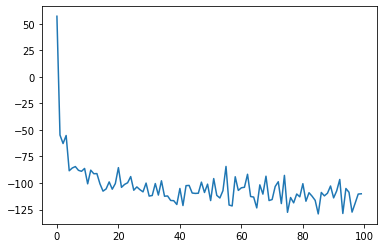

In [20]:
plt.plot(hist.history['loss'])
plt.show()

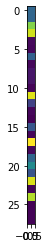

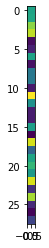

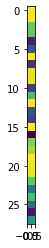

In [43]:
seq = np.random.random((28,1))
plt.imshow(pixel_cnn.predict(seq).reshape(28,1))
plt.show()
plt.imshow(seq)
plt.show()
plt.imshow(seq-pixel_cnn.predict(seq).reshape(28,1))

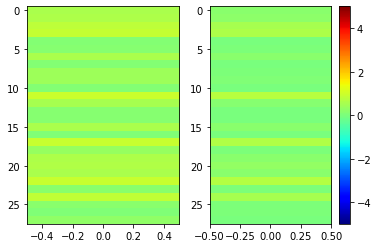

In [51]:
plt.subplot(1, 2, 1)
plt.imshow(seq, vmin=-5, vmax=5, cmap='jet', aspect='auto')
plt.subplot(1, 2, 2)
plt.imshow(pixel_cnn.predict(seq).reshape(28,1), vmin=-5, vmax=5, cmap='jet', aspect='auto')
plt.colorbar()

In [49]:
pixel_cnn(seq).sample()

<tf.Tensor: shape=(28, 1, 1), dtype=float32, numpy=
array([[[ 2.0971757e-01]],

       [[ 2.0853369e-01]],

       [[ 5.7056743e-01]],

       [[ 5.2681899e-01]],

       [[ 1.1434085e-02]],

       [[-1.4872286e-03]],

       [[ 1.9894464e-01]],

       [[ 6.9658109e-03]],

       [[ 2.4975747e-02]],

       [[ 3.4848716e-02]],

       [[ 4.1500636e-05]],

       [[ 6.5648180e-01]],

       [[ 1.0504401e-01]],

       [[ 2.4598925e-03]],

       [[-3.7073959e-03]],

       [[ 1.7077190e-01]],

       [[ 3.3144313e-03]],

       [[ 6.1454052e-01]],

       [[ 1.5206153e-02]],

       [[ 1.9228107e-01]],

       [[ 2.7804214e-01]],

       [[ 1.6186319e-01]],

       [[ 6.1516356e-01]],

       [[-1.7056708e-01]],

       [[ 5.4616743e-01]],

       [[ 2.5906002e-03]],

       [[-2.8486946e-03]],

       [[-3.9793984e-03]]], dtype=float32)>

In [37]:
pixel_cnn.layers[-1].sample()

AttributeError: 'MixtureNormal' object has no attribute 'sample'

In [17]:
"""
## Build the model based on the original paper
"""

inputs = keras.Input(shape=(28,1))
x = PixelConvLayer(
    mask_type="A", filters=128, kernel_size=7, activation="relu", padding="same"
)(inputs)

for _ in range(n_residual_blocks):
    x = ResidualBlock(filters=128)(x)

for _ in range(2):
    x = PixelConvLayer(
        mask_type="B",
        filters=128,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

#out = keras.layers.Conv1D(
#    filters=1, kernel_size=1, strides=1, activation="sigmoid", padding="valid"
#)(x)

out = tfp.layers.MixtureNormal(num_components, event_shape)(x)


pixel_cnn = keras.Model(inputs, out)


In [ ]:
negloglik = lambda y, q: -q.log_prob(y)


In [18]:
adam = keras.optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss=negloglik)

pixel_cnn.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 1)]           0         
_________________________________________________________________
pixel_conv_layer (PixelConvL (None, 28, 128)           1024      
_________________________________________________________________
residual_block (ResidualBloc (None, 28, 128)           49472     
_________________________________________________________________
residual_block_1 (ResidualBl (None, 28, 128)           49472     
_________________________________________________________________
residual_block_2 (ResidualBl (None, 28, 128)           49472     
_________________________________________________________________
residual_block_3 (ResidualBl (None, 28, 128)           49472     
_________________________________________________________________
residual_block_4 (ResidualBl (None, 28, 128)           49472 

In [52]:
from tensorflow.keras.utils import plot_model

plot_model(pixel_cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
pixel_cnn.fit(
    x=data, y=data, batch_size=128, epochs=50, validation_split=0.1, verbose=2
)


In [ ]:
"""
## Demonstration
The PixelCNN cannot generate the full image at once. Instead, it must generate each pixel in
order, append the last generated pixel to the current image, and feed the image back into the
model to repeat the process.
"""

from IPython.display import Image, display

# Create an empty array of pixels.
batch = 4
pixels = np.zeros(shape=(batch,) + (pixel_cnn.input_shape)[1:])
batch, rows, cols, channels = pixels.shape

# Iterate over the pixels because generation has to be done sequentially pixel by pixel.
for row in tqdm(range(rows)):
    for col in range(cols):
        for channel in range(channels):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = pixel_cnn.predict(pixels)[:, row, col, channel]
            # Use the probabilities to pick pixel values and append the values to the image
            # frame.
            pixels[:, row, col, channel] = tf.math.ceil(
                probs - tf.random.uniform(probs.shape)
            )



In [ ]:

def deprocess_image(x):
    # Stack the single channeled black and white image to rgb values.
    x = np.stack((x, x, x), 2)
    # Undo preprocessing
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x


# Iterate over the generated images and plot them with matplotlib.
for i, pic in enumerate(pixels):
    keras.preprocessing.image.save_img(
        "generated_image_{}.png".format(i), deprocess_image(np.squeeze(pic, -1))
    )

display(Image("generated_image_0.png"))
display(Image("generated_image_1.png"))
display(Image("generated_image_2.png"))
display(Image("generated_image_3.png"))

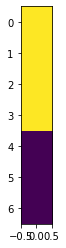

In [22]:
mask_type = "B"
kernel_shape=pixel_cnn.layers[1].conv.kernel.get_shape()
mask = np.zeros(shape=kernel_shape)
mask[: kernel_shape[0] // 2, ...] = 1.0
mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
if mask_type == "B":
    mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0
    
plt.imshow(mask[...,0])

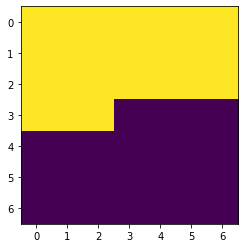